In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics as m
from sklearn.metrics import roc_curve, auc, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [ ]:
dataset_original = pd.read_csv('data.csv')
print(f"Boyut: {dataset_original.shape}")
print(f"Sütunlar: {list(dataset_original.columns)}")
print(dataset_original.head(3))
print(f"\nEksik değerler:\n{dataset_original.isnull().sum()[dataset_original.isnull().sum() > 0]}")

Boyut: (569, 33)
Sütunlar: ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32']
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38           122.8     1001.0   
1    842517         M        20.57         17.77           132.9     1326.0   
2  84300903         M        19.69         21.25           130.0     1203.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \

In [ ]:
dataset = dataset_original.iloc[:, :-1]

print(f"Boyut: {dataset.shape}")
print(f"Çıkarılan sütun: 'Unnamed: 32' (tamamen NaN içeriyordu)")

Boyut: (569, 32)
Çıkarılan sütun: 'Unnamed: 32' (tamamen NaN içeriyordu)


In [ ]:
dataset = dataset.drop('id', axis=1)

print(f"Boyut: {dataset.shape}")
print(f"Çıkarılan sütun: 'id' (tahmin için gereksiz tanımlayıcı)")
print(f"\nKalan sütunlar ({len(dataset.columns)}):")
print(list(dataset.columns))


Boyut: (569, 31)
Çıkarılan sütun: 'id' (tahmin için gereksiz tanımlayıcı)

Kalan sütunlar (31):
['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']


In [ ]:
# Label encoding
le = LabelEncoder()
dataset['diagnosis'] = le.fit_transform(dataset['diagnosis'])

print(f"Diagnosis değerleri: {dataset_original['diagnosis'].unique()} → {dataset['diagnosis'].unique()}")
print(f"Encoding: B (Benign/İyi huylu) = 0, M (Malignant/Kötü huylu) = 1")
print(f"Sınıf dağılımı:")
print(dataset['diagnosis'].value_counts())

Diagnosis değerleri: ['M' 'B'] → [1 0]
Encoding: B (Benign/İyi huylu) = 0, M (Malignant/Kötü huylu) = 1
Sınıf dağılımı:
diagnosis
0    357
1    212
Name: count, dtype: int64


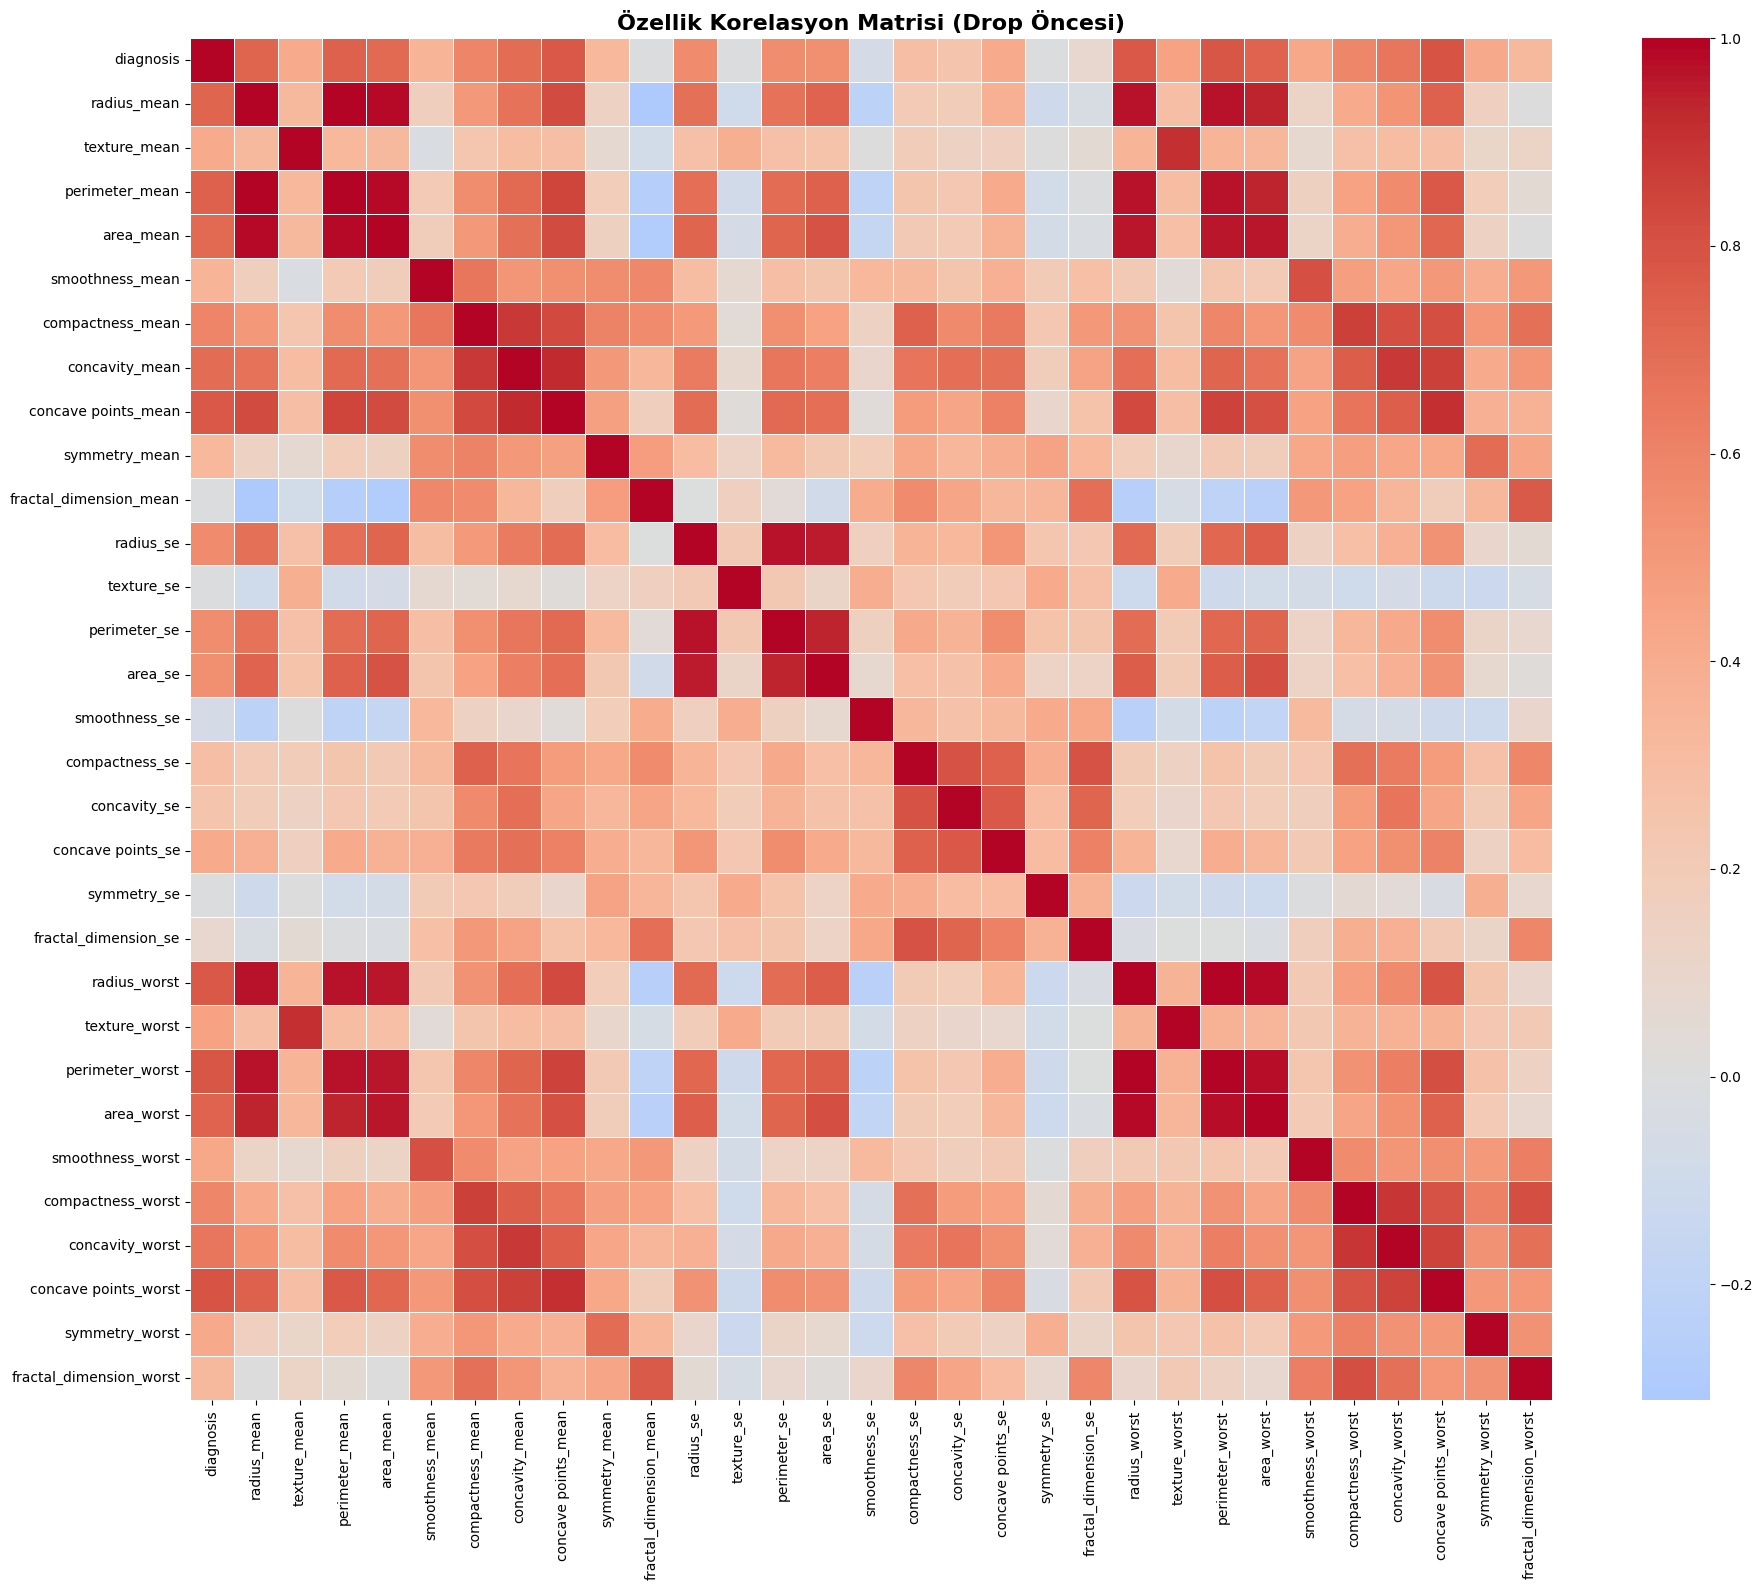

In [ ]:
# Korelasyon analizi için heatmap

plt.figure(figsize=(20, 16))
correlation_matrix = dataset.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Özellik Korelasyon Matrisi (Drop Öncesi)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_before_drop.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Yüksek korelasyonlu özellikler
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.9 and correlation_matrix.columns[i] != 'diagnosis':
            high_corr_pairs.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlation': correlation_matrix.iloc[i, j]
            })

if high_corr_pairs:
    print("\n  Yüksek Korelasyonlu Özellik Çiftleri (>0.9):")
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', ascending=False)
    print(high_corr_df.to_string(index=False))


  Yüksek Korelasyonlu Özellik Çiftleri (>0.9):
          Feature 1            Feature 2  Correlation
        radius_mean       perimeter_mean     0.997855
       radius_worst      perimeter_worst     0.993708
        radius_mean            area_mean     0.987357
     perimeter_mean            area_mean     0.986507
       radius_worst           area_worst     0.984015
    perimeter_worst           area_worst     0.977578
          radius_se         perimeter_se     0.972794
     perimeter_mean      perimeter_worst     0.970387
        radius_mean         radius_worst     0.969539
     perimeter_mean         radius_worst     0.969476
        radius_mean      perimeter_worst     0.965137
          area_mean         radius_worst     0.962746
          area_mean           area_worst     0.959213
          area_mean      perimeter_worst     0.959120
          radius_se              area_se     0.951830
     perimeter_mean           area_worst     0.941550
        radius_mean           area

In [ ]:
# Çıkarılacak özellikleri
features_to_drop = ['perimeter_mean', 'area_mean', 'compactness_mean',
                    'concave points_mean', 'perimeter_se', 'area_se',
                    'compactness_se', 'concave points_se', 'perimeter_worst',
                    'area_worst', 'compactness_worst', 'concave points_worst',
                    'texture_worst', 'texture_mean', 'concavity_worst']

print(f"\n YÜKSEK KORELASYONLU ÖZELLİKLER ÇIKARILACAK:")
print("-" * 80)
print(f"Çıkarılacak özellikler ({len(features_to_drop)}):")
for i, feature in enumerate(features_to_drop, 1):
    print(f"  {i}. {feature}")

print("\nNeden çıkarılıyor?")
print("  • Perimeter ve Area: Radius ile yüksek korelasyon (0.99+)")
print("  • Compactness ve Concave points: Diğer shape özellikleri ile yüksek korelasyon")
print("  • Texture: Tahmin gücü düşük")
print("  • Concavity_worst: Diğer worst özellikleri ile çok yüksek korelasyon")
print("  → Multicollinearity'yi azaltmak ve modeli basitleştirmek için")


 YÜKSEK KORELASYONLU ÖZELLİKLER ÇIKARILACAK:
--------------------------------------------------------------------------------
Çıkarılacak özellikler (15):
  1. perimeter_mean
  2. area_mean
  3. compactness_mean
  4. concave points_mean
  5. perimeter_se
  6. area_se
  7. compactness_se
  8. concave points_se
  9. perimeter_worst
  10. area_worst
  11. compactness_worst
  12. concave points_worst
  13. texture_worst
  14. texture_mean
  15. concavity_worst

Neden çıkarılıyor?
  • Perimeter ve Area: Radius ile yüksek korelasyon (0.99+)
  • Compactness ve Concave points: Diğer shape özellikleri ile yüksek korelasyon
  • Texture: Tahmin gücü düşük
  • Concavity_worst: Diğer worst özellikleri ile çok yüksek korelasyon
  → Multicollinearity'yi azaltmak ve modeli basitleştirmek için


In [ ]:
dataset = dataset.drop(features_to_drop, axis=1)

print(f"Boyut: {dataset.shape}")
print(f"Özellik sayısı: {dataset.shape[1] - 1} (diagnosis hariç)")
print(f"\nKalan özellikler ({len(dataset.columns)}):")
for i, col in enumerate(dataset.columns, 1):
    print(f"  {i}. {col}")

Boyut: (569, 16)
Özellik sayısı: 15 (diagnosis hariç)

Kalan özellikler (16):
  1. diagnosis
  2. radius_mean
  3. smoothness_mean
  4. concavity_mean
  5. symmetry_mean
  6. fractal_dimension_mean
  7. radius_se
  8. texture_se
  9. smoothness_se
  10. concavity_se
  11. symmetry_se
  12. fractal_dimension_se
  13. radius_worst
  14. smoothness_worst
  15. symmetry_worst
  16. fractal_dimension_worst


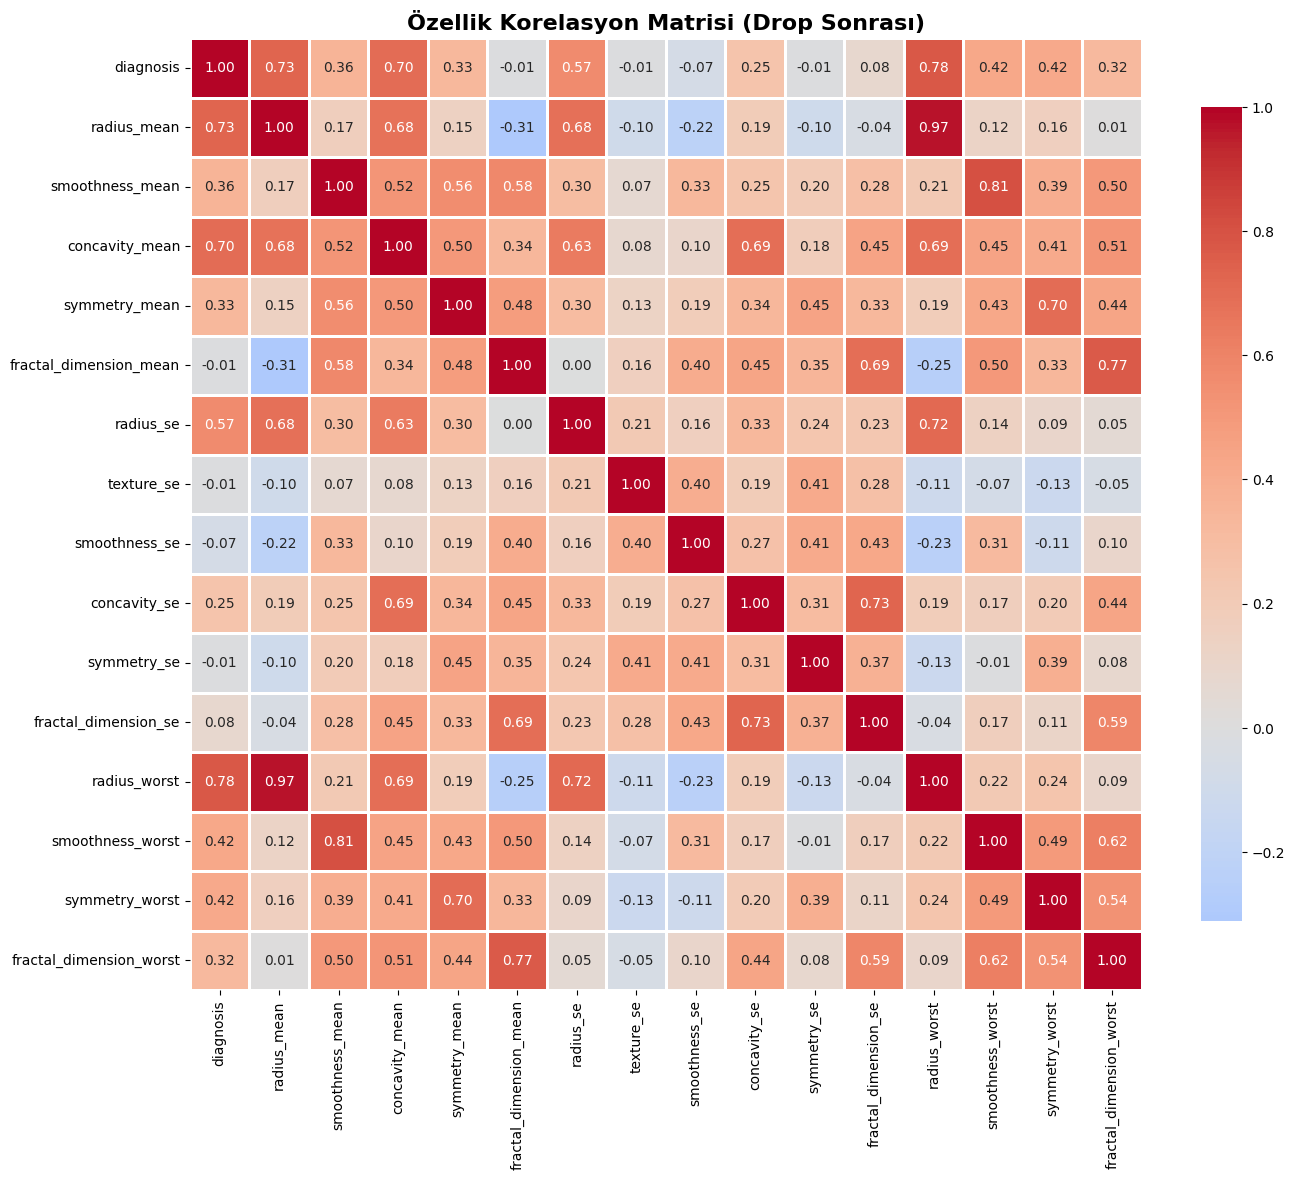

In [ ]:
plt.figure(figsize=(14, 12))
final_correlation = dataset.corr()
sns.heatmap(final_correlation, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Özellik Korelasyon Matrisi (Drop Sonrası)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_after_drop.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
print(dataset.describe())

        diagnosis  radius_mean  smoothness_mean  concavity_mean  \
count  569.000000   569.000000       569.000000      569.000000   
mean     0.372583    14.127292         0.096360        0.088799   
std      0.483918     3.524049         0.014064        0.079720   
min      0.000000     6.981000         0.052630        0.000000   
25%      0.000000    11.700000         0.086370        0.029560   
50%      0.000000    13.370000         0.095870        0.061540   
75%      1.000000    15.780000         0.105300        0.130700   
max      1.000000    28.110000         0.163400        0.426800   

       symmetry_mean  fractal_dimension_mean   radius_se  texture_se  \
count     569.000000              569.000000  569.000000  569.000000   
mean        0.181162                0.062798    0.405172    1.216853   
std         0.027414                0.007060    0.277313    0.551648   
min         0.106000                0.049960    0.111500    0.360200   
25%         0.161900                

In [ ]:
features = dataset.iloc[:, 1:]
labels = dataset.iloc[:, 0]

In [ ]:
# Train-test split
feature_train, feature_test, label_train, label_test = train_test_split(
    features, labels, test_size=0.2, random_state=42
)

print(f"Veri Seti Bilgisi:")
print(f"Toplam örnek sayısı: {len(dataset)}")
print(f"Eğitim seti: {len(feature_train)}")
print(f"Test seti: {len(feature_test)}")
print(f"Özellik sayısı: {features.shape[1]}")
print(f"Sınıf dağılımı - B (Benign): {sum(labels==0)}, M (Malignant): {sum(labels==1)}")

Veri Seti Bilgisi:
Toplam örnek sayısı: 569
Eğitim seti: 455
Test seti: 114
Özellik sayısı: 15
Sınıf dağılımı - B (Benign): 357, M (Malignant): 212


In [ ]:
# HYPERPARAMETER TUNING

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],
    'weights': ['uniform', 'distance']
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(feature_train, label_train)

print(f"\nEn iyi parametreler: {grid_search.best_params_}")
print(f"En iyi cross-validation skoru: {grid_search.best_score_:.4f}")


En iyi parametreler: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}
En iyi cross-validation skoru: 0.9385


In [ ]:
# Test edilecek konfigürasyonlar
configs = [
    {'name': 'K=3, Euclidean', 'n_neighbors': 3, 'metric': 'euclidean', 'weights': 'uniform'},
    {'name': 'K=5, Euclidean', 'n_neighbors': 5, 'metric': 'euclidean', 'weights': 'uniform'},
    {'name': 'K=7, Euclidean', 'n_neighbors': 7, 'metric': 'euclidean', 'weights': 'uniform'},
    {'name': 'K=5, Manhattan', 'n_neighbors': 5, 'metric': 'manhattan', 'weights': 'uniform'},
    {'name': 'K=5, Minkowski', 'n_neighbors': 5, 'metric': 'minkowski', 'weights': 'uniform'},
    {'name': 'K=5, Chebyshev', 'n_neighbors': 5, 'metric': 'chebyshev', 'weights': 'uniform'},
    {'name': 'K=5, Euclidean, Weighted', 'n_neighbors': 5, 'metric': 'euclidean', 'weights': 'distance'},
    {'name': 'Best Model', 'n_neighbors': grid_search.best_params_['n_neighbors'],
     'metric': grid_search.best_params_['metric'], 'weights': grid_search.best_params_['weights']}
]

results = []

for config in configs:
    model = KNeighborsClassifier(
        n_neighbors=config['n_neighbors'],
        metric=config['metric'],
        weights=config['weights']
    )
    model.fit(feature_train, label_train)

    y_pred = model.predict(feature_test)
    y_pred_proba = model.predict_proba(feature_test)[:, 1]

    # Confusion Matrix
    cm = m.confusion_matrix(label_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = m.accuracy_score(label_test, y_pred)
    precision = m.precision_score(label_test, y_pred)
    recall = m.recall_score(label_test, y_pred)
    specificity = tn / (tn + fp)
    f1 = m.f1_score(label_test, y_pred)
    roc_auc = roc_auc_score(label_test, y_pred_proba)

    results.append({
        'Konfigürasyon': config['name'],
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall (Sensitivity)': recall,
        'Specificity': specificity,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn,
        'y_pred_proba': y_pred_proba
    })

results_df = pd.DataFrame(results)

In [ ]:
# PERFORMANS METRİKLERİ TABLOSU

metrics_table = results_df[['Konfigürasyon', 'Accuracy', 'Precision',
                             'Recall (Sensitivity)', 'Specificity', 'F1-Score', 'ROC-AUC']]
print("\n" + metrics_table.to_string(index=False))

best_idx = results_df['F1-Score'].idxmax()
print(f"\n En İyi Performans: {results_df.loc[best_idx, 'Konfigürasyon']}")
print(f"   F1-Score: {results_df.loc[best_idx, 'F1-Score']:.4f}")


           Konfigürasyon  Accuracy  Precision  Recall (Sensitivity)  Specificity  F1-Score  ROC-AUC
          K=3, Euclidean  0.947368   0.930233              0.930233     0.957746  0.930233 0.967409
          K=5, Euclidean  0.964912   0.975610              0.930233     0.985915  0.952381 0.969047
          K=7, Euclidean  0.947368   0.974359              0.883721     0.985915  0.926829 0.977891
          K=5, Manhattan  0.956140   0.975000              0.906977     0.985915  0.939759 0.979201
          K=5, Minkowski  0.964912   0.975610              0.930233     0.985915  0.952381 0.969047
          K=5, Chebyshev  0.929825   0.948718              0.860465     0.971831  0.902439 0.976580
K=5, Euclidean, Weighted  0.964912   0.975610              0.930233     0.985915  0.952381 0.968883
              Best Model  0.947368   0.951220              0.906977     0.971831  0.928571 0.962496

 En İyi Performans: K=5, Euclidean
   F1-Score: 0.9524


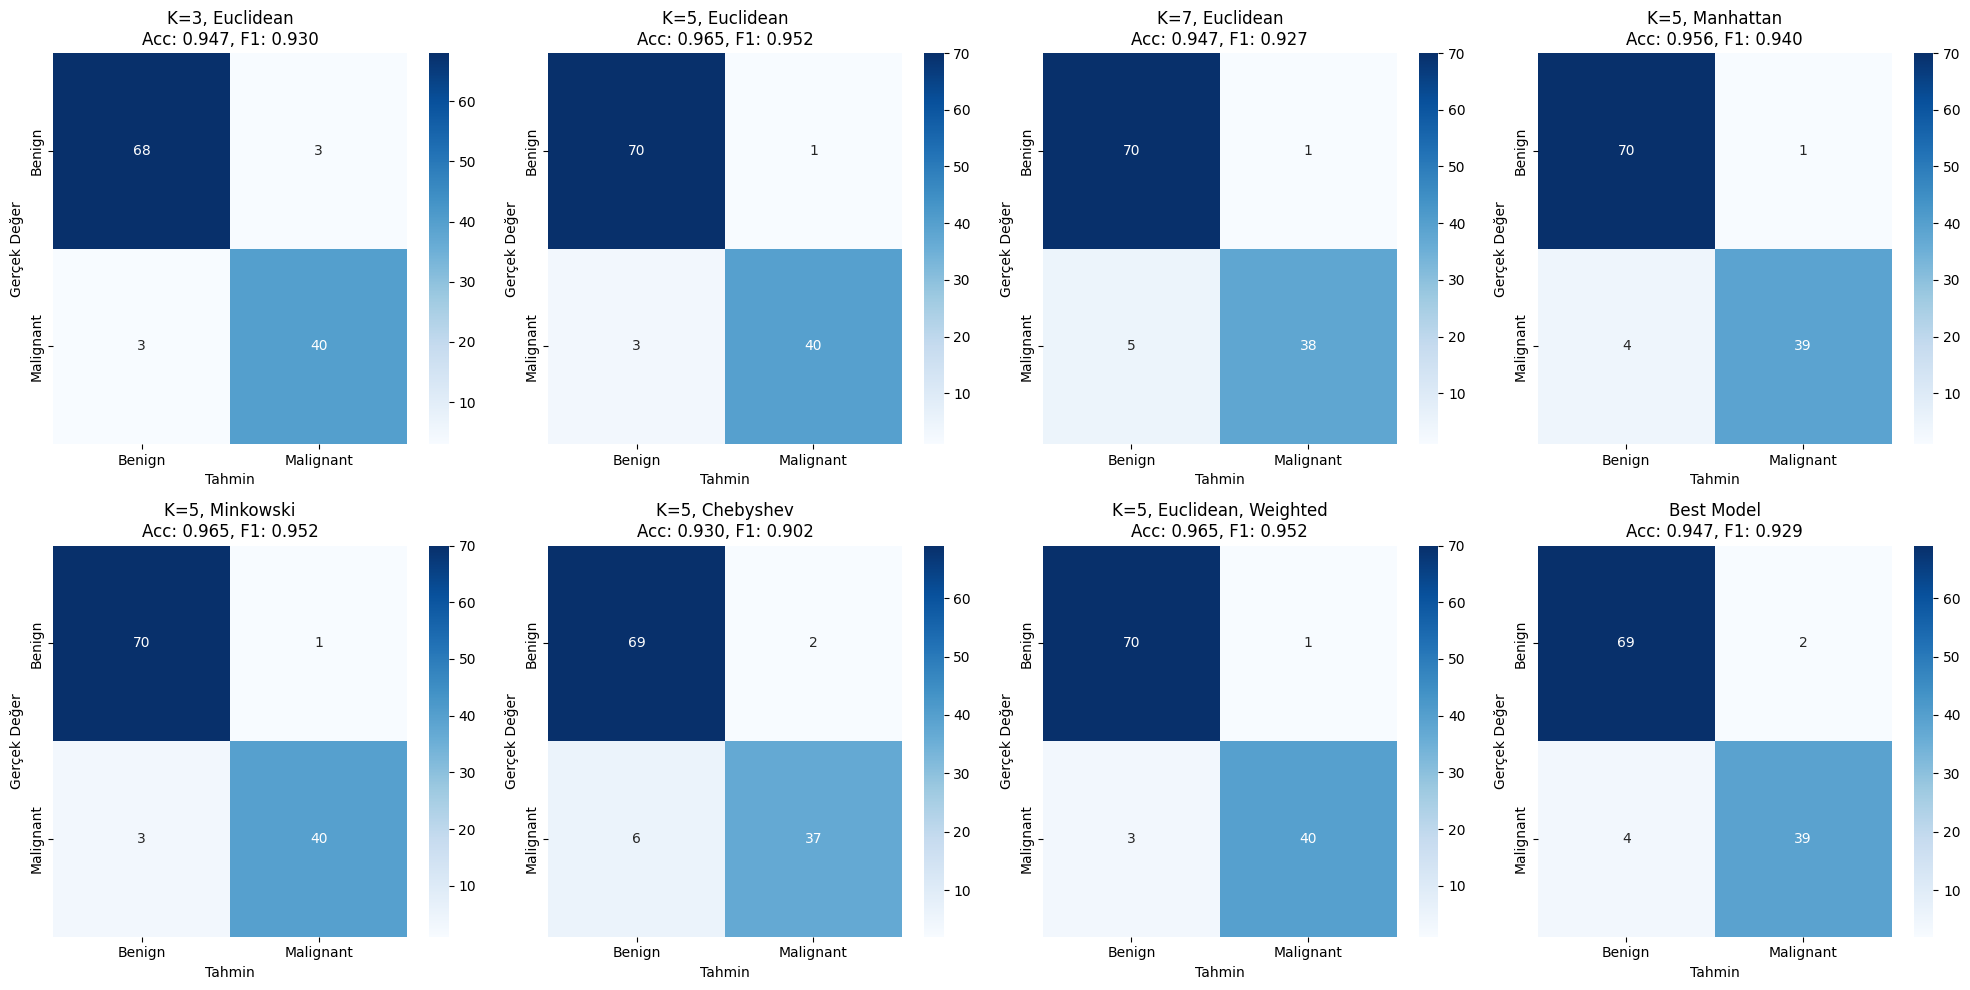

In [ ]:
# CONFUSION MATRIX

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for idx, result in enumerate(results):
    cm = np.array([[result['TN'], result['FP']],
                   [result['FN'], result['TP']]])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Benign', 'Malignant'],
                yticklabels=['Benign', 'Malignant'])
    axes[idx].set_title(f"{result['Konfigürasyon']}\nAcc: {result['Accuracy']:.3f}, F1: {result['F1-Score']:.3f}")
    axes[idx].set_ylabel('Gerçek Değer')
    axes[idx].set_xlabel('Tahmin')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

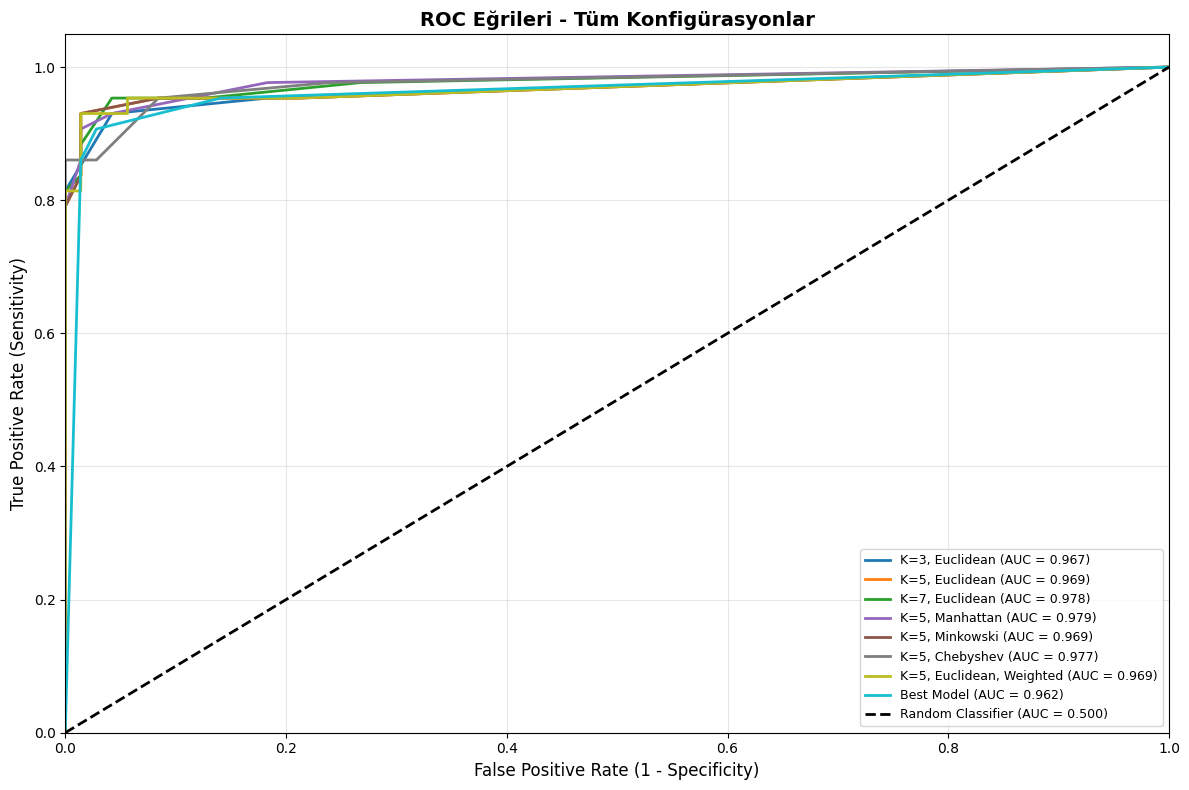

In [ ]:
# ROC EĞRİLERİ

plt.figure(figsize=(12, 8))

colors = plt.cm.tab10(np.linspace(0, 1, len(results)))

for idx, result in enumerate(results):
    fpr, tpr, _ = roc_curve(label_test, result['y_pred_proba'])
    plt.plot(fpr, tpr, label=f"{result['Konfigürasyon']} (AUC = {result['ROC-AUC']:.3f})",
             linewidth=2, color=colors[idx])

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.500)', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('ROC Eğrileri - Tüm Konfigürasyonlar', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

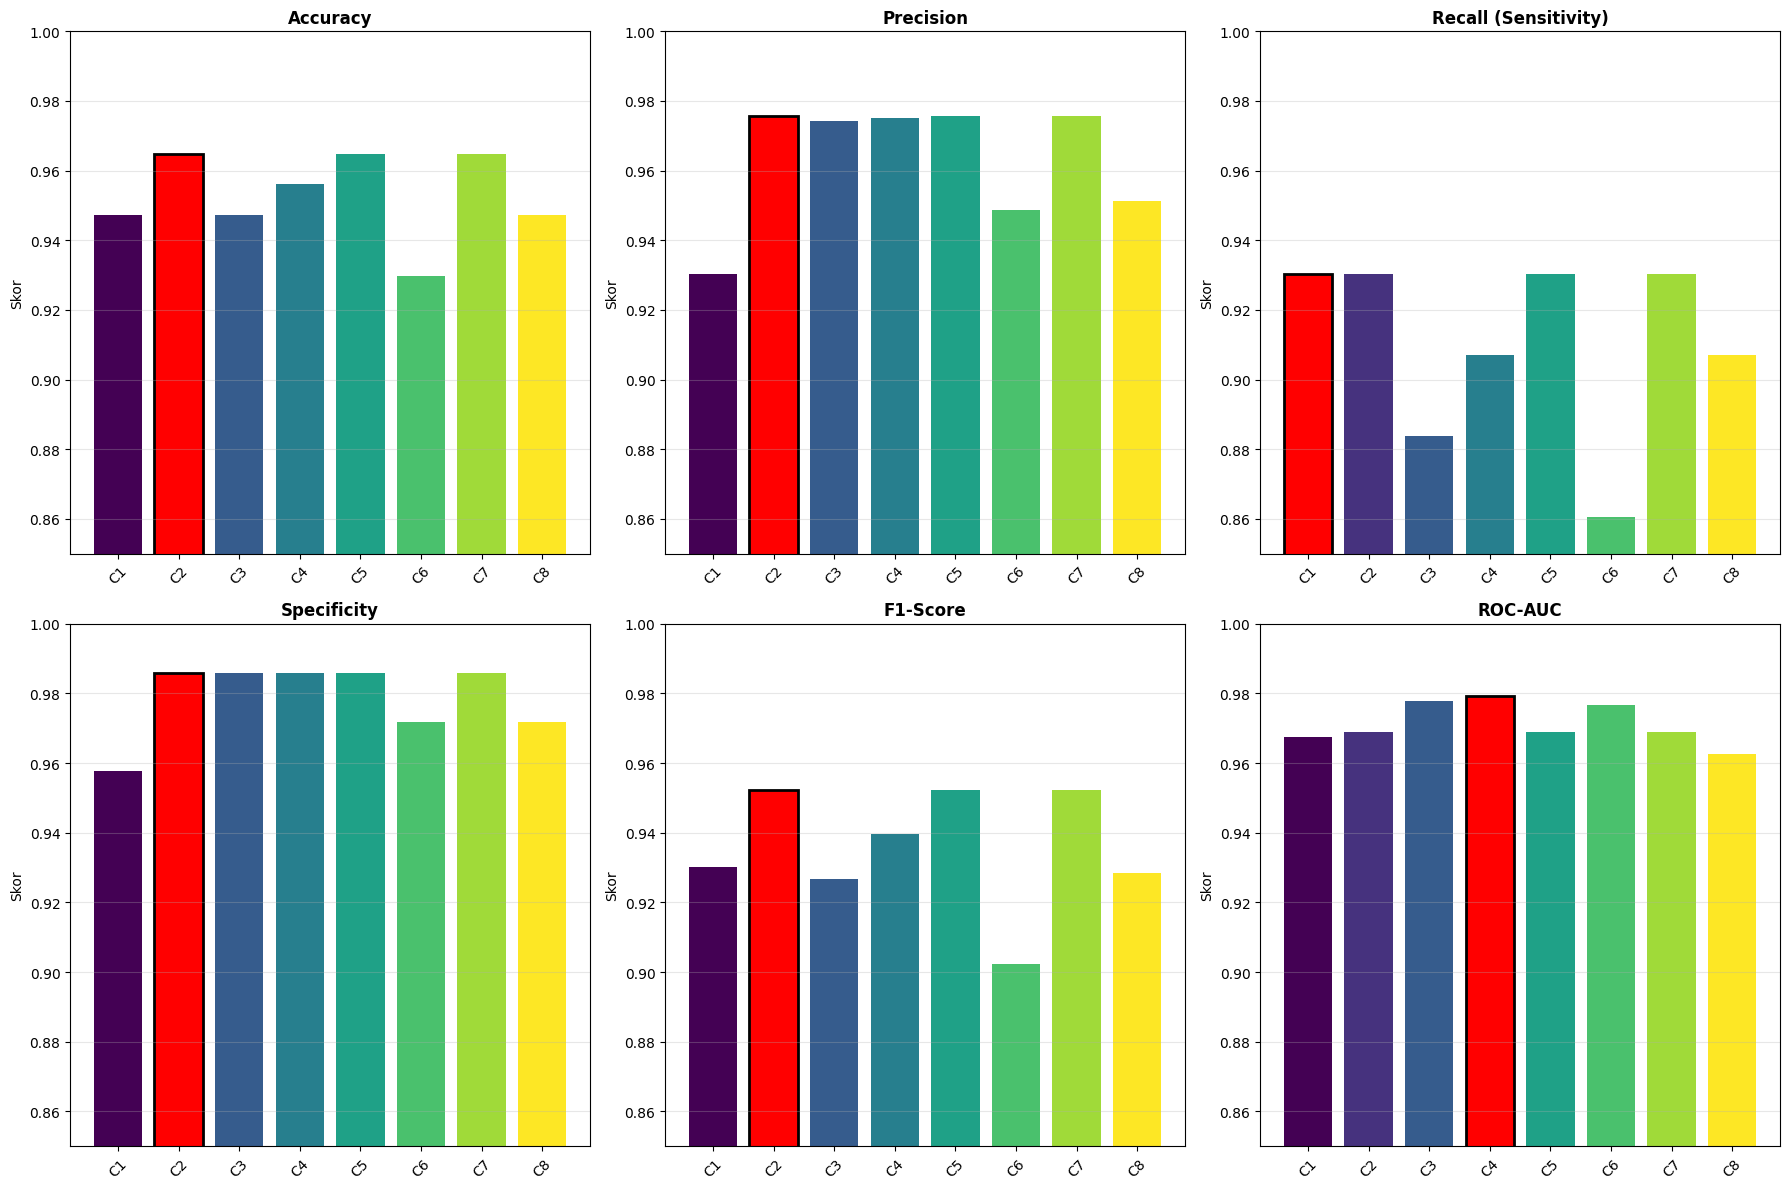


Konfigürasyon Etiketleri:
C1: K=3, Euclidean
C2: K=5, Euclidean
C3: K=7, Euclidean
C4: K=5, Manhattan
C5: K=5, Minkowski
C6: K=5, Chebyshev
C7: K=5, Euclidean, Weighted
C8: Best Model


In [ ]:
# METRİK KARŞILAŞTIRMA GRAFİKLERİ

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

metrics = ['Accuracy', 'Precision', 'Recall (Sensitivity)', 'Specificity', 'F1-Score', 'ROC-AUC']
colors_list = plt.cm.viridis(np.linspace(0, 1, len(results_df)))

for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    bars = ax.bar(range(len(results_df)), results_df[metric], color=colors_list)
    ax.set_title(metric, fontsize=12, fontweight='bold')
    ax.set_ylabel('Skor', fontsize=10)
    ax.set_xticks(range(len(results_df)))
    ax.set_xticklabels([f"C{i+1}" for i in range(len(results_df))], rotation=45)
    ax.set_ylim([0.85, 1.0])
    ax.grid(axis='y', alpha=0.3)


    best_val = results_df[metric].max()
    best_idx_metric = results_df[metric].idxmax()
    bars[best_idx_metric].set_color('red')
    bars[best_idx_metric].set_edgecolor('black')
    bars[best_idx_metric].set_linewidth(2)

plt.tight_layout()
plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Konfigürasyon legend'ı
print("\nKonfigürasyon Etiketleri:")
for i, config in enumerate(configs):
    print(f"C{i+1}: {config['name']}")

In [ ]:
# DETAYLI ANALİZ VE YORUM

print("\n HYPERPARAMETER ETKİLERİ:")

# K değeri etkisi
k_effect = results_df[results_df['Konfigürasyon'].str.contains('Euclidean') &
                      ~results_df['Konfigürasyon'].str.contains('Weighted|Best')].sort_values('Konfigürasyon')
print("\n1. K Değerinin Etkisi (Euclidean metriği ile):")
for _, row in k_effect.iterrows():
    print(f"   {row['Konfigürasyon']}: F1-Score = {row['F1-Score']:.4f}, Accuracy = {row['Accuracy']:.4f}")
print("   → Küçük k değerleri overfitting, büyük k değerleri underfitting riskini artırır.")

# Uzaklık metriği etkisi
metric_effect = results_df[results_df['Konfigürasyon'].str.contains('K=5') &
                           ~results_df['Konfigürasyon'].str.contains('Best')].sort_values('F1-Score', ascending=False)
print("\n2. Uzaklık Metriğinin Etkisi (K=5 ile):")
for _, row in metric_effect.iterrows():
    print(f"   {row['Konfigürasyon']}: F1-Score = {row['F1-Score']:.4f}, ROC-AUC = {row['ROC-AUC']:.4f}")
print("   → Farklı uzaklık metrikleri veri dağılımına göre farklı performans gösterir.")

print("\n ÖNERİLER:")
best_config = results_df.loc[best_idx]
print(f"• En iyi model: {best_config['Konfigürasyon']}")
print(f"• Bu model şu metriklerde üstün performans gösterdi:")
print(f"  - Accuracy: {best_config['Accuracy']:.4f}")
print(f"  - F1-Score: {best_config['F1-Score']:.4f}")
print(f"  - ROC-AUC: {best_config['ROC-AUC']:.4f}")
print(f"  - Sensitivity: {best_config['Recall (Sensitivity)']:.4f}")
print(f"  - Specificity: {best_config['Specificity']:.4f}")
print("\n• Tıbbi uygulamalarda Sensitivity (duyarlılık) kritik öneme sahiptir.")
print("  Kanser tespitinde False Negative (kaçırılan hasta) en tehlikeli durumdur.")

# Sensitivity karşılaştırması
best_sensitivity_idx = results_df['Recall (Sensitivity)'].idxmax()
print(f"\n• En yüksek Sensitivity: {results_df.loc[best_sensitivity_idx, 'Konfigürasyon']}")
print(f"  Sensitivity: {results_df.loc[best_sensitivity_idx, 'Recall (Sensitivity)']:.4f}")
print(f"  (Sadece {int(results_df.loc[best_sensitivity_idx, 'FN'])} hasta kaçırıldı)")


 HYPERPARAMETER ETKİLERİ:

1. K Değerinin Etkisi (Euclidean metriği ile):
   K=3, Euclidean: F1-Score = 0.9302, Accuracy = 0.9474
   K=5, Euclidean: F1-Score = 0.9524, Accuracy = 0.9649
   K=7, Euclidean: F1-Score = 0.9268, Accuracy = 0.9474
   → Küçük k değerleri overfitting, büyük k değerleri underfitting riskini artırır.

2. Uzaklık Metriğinin Etkisi (K=5 ile):
   K=5, Euclidean: F1-Score = 0.9524, ROC-AUC = 0.9690
   K=5, Minkowski: F1-Score = 0.9524, ROC-AUC = 0.9690
   K=5, Euclidean, Weighted: F1-Score = 0.9524, ROC-AUC = 0.9689
   K=5, Manhattan: F1-Score = 0.9398, ROC-AUC = 0.9792
   K=5, Chebyshev: F1-Score = 0.9024, ROC-AUC = 0.9766
   → Farklı uzaklık metrikleri veri dağılımına göre farklı performans gösterir.

 ÖNERİLER:
• En iyi model: K=5, Euclidean
• Bu model şu metriklerde üstün performans gösterdi:
  - Accuracy: 0.9649
  - F1-Score: 0.9524
  - ROC-AUC: 0.9690
  - Sensitivity: 0.9302
  - Specificity: 0.9859

• Tıbbi uygulamalarda Sensitivity (duyarlılık) kritik öneme 